# 0 Loading packages <a name="loading"></a> 

In [1]:
import sys
print(sys.executable)
print(sys.path)
print(sys.version)

/home2/s418610/.conda/envs/py37_res_PAGA/bin/python
['/home2/s418610/jupyter_notebooks/03.Invivo_neuronal_reprogramming/Manuscript/to_GitHub', '', '/cm/shared/apps/cnvkit/0.9.5/lib/python3.6/site-packages', '/cm/shared/apps/python/3.6.4-anaconda/lib', '/cm/shared/apps/jupyterkernel-matlab/0.16.1/lib/python3.6/site-packages', '/cm/shared/apps/python/2.7.x-anaconda/lib', '/home2/s418610/.conda/envs/py37_res_PAGA/lib/python37.zip', '/home2/s418610/.conda/envs/py37_res_PAGA/lib/python3.7', '/home2/s418610/.conda/envs/py37_res_PAGA/lib/python3.7/lib-dynload', '/home2/s418610/.local/lib/python3.7/site-packages', '/home2/s418610/.conda/envs/py37_res_PAGA/lib/python3.7/site-packages', '/home2/s418610/.conda/envs/py37_res_PAGA/lib/python3.7/site-packages/fa2-0.3.5-py3.7-linux-x86_64.egg', '/home2/s418610/.conda/envs/py37_res_PAGA/lib/python3.7/site-packages/IPython/extensions', '/home2/s418610/.ipython']
3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


In [2]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.sparse
import sklearn.manifold
import statsmodels.api as sm

# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pyclustering.cluster.kmedoids import kmedoids

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# import seaborn as sb

import scanpy as sc
import harmonypy as hm

In [3]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

print('numpy', np.__version__)
print('pandas', pd.__version__)
print('scipy', scipy.__version__)
print('sklearn', sklearn.__version__)
print('statsmodels', sm.__version__)
print('matplotlib', mpl.__version__)
print('seaborn', sns.__version__)

sc.logging.print_versions()

!date +%F

numpy 1.17.2
pandas 0.25.2
scipy 1.3.1
sklearn 0.21.3
statsmodels 0.10.1
matplotlib 3.3.2
seaborn 0.9.0
scanpy==1.4.5.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1
2021-08-04


In [4]:
import anndata
import pickle

In [5]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [6]:
from scipy.stats import chi2_contingency

In [7]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

In [8]:
import os

# set a working directory for saving plots
wdir = "/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/99.Manuscript/Figures_revision/"
os.chdir( wdir )

In [9]:
data_dir = '/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/analysis/Cluster_with_10X_20k/data/10x_remapped/Revision/'

In [10]:
neural_data_dir = data_dir + 'NeuralOnly/'

In [11]:
geneclustering_dir = data_dir + 'GeneClustering/'

# 1 Load and label data

In [17]:
# Load BL41 and BL42 with 10X datasets (output file of cellranger count aggr)
adata = sc.read_10x_h5('/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/BL41-42_with_10X/1.3M_brain_11_51/aggr_10x/outs/filtered_feature_bc_matrix.h5')

reading /project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/BL41-42_with_10X/1.3M_brain_11_51/aggr_10x/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:03)


In [14]:
adata_neural = sc.read(neural_data_dir + 'ReprAlone_NeuralOnly_postFiltering_log_pcs50_Harmony_louvain_ann_rankPseudotime.h5ad')

In [18]:
adata = adata[adata_neural.obs.index,:]

In [19]:
adata.obs = adata_neural.obs

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [20]:
adata.var_names_make_unique()

In [21]:
adata

AnnData object with n_obs × n_vars = 4607 × 31055 
    obs: 'library_name', 'batch', 'lenti_count', 'lenti_log1p_count', 'tdT_count', 'tdT_log1p_count', 'doublet_scores', 'predicted_doublets', 'n_counts', 'log_counts', 'n_genes', 'mt_count', 'mt_frac', 'n_counts_all', 'louvain', 'dpt_pseudotime', 'rank_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome'

# 4 Gene clustering

### 4.1 Use chi-square test to filter genes

#### Load and prep raw count matrix

In [22]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Remove genes expressed in < 50 (~1%) of the cells
sc.pp.filter_genes(adata, min_cells=50)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 31055
filtered out 18755 genes that are detected in less than 50 cells
Number of genes after cell filter: 12300


#### Use chi-square test to remove genes not enriched in any cell cluster(s)
* i.e. genes that are (more or less) uniformly expressed across all clusters

In [23]:
cluster_size = adata.obs['louvain'].value_counts()

In [25]:
cluster_size

Lenti-astrocytes    683
Astrocytes-1        657
Neuroblasts-1       594
Neuroblasts-2       571
Neuroblasts-3       435
Neuroblasts-4       386
NPCs-1              383
Astrocytes-2        362
Neuroblasts-5       268
NPCs-2              202
Astrocytes-3         48
Neurons              18
Name: louvain, dtype: int64

In [26]:
# gene = adata.var.index[0]
df_tmp = pd.DataFrame(adata.obs['louvain'])
genes_keep = []
for gene in adata.var.index: 
    df_tmp['gene_expressed'] = adata[:,gene].X > 0
#    df_tmp['gene_expressed'] = adata[:,gene].X.toarray() > 0

#    df_tmp[df_tmp['gene_expressed']]['louvain'].value_counts()[expression_table.index]

    expression_table = pd.DataFrame(df_tmp[df_tmp['gene_expressed']]['louvain'].value_counts()[cluster_size.index])

    expression_table.columns = ['positive_cells']

    expression_table['negative_cells'] = cluster_size.values - expression_table['positive_cells']

    if expression_table['negative_cells'].sum() == 0:
        genes_keep.append((gene, 1)) 
        continue
#    expression_table

    # Make contigency table with the format:
    # [[queried cluster pos, rest clusters pos],
    #  [queried cluster neg, rest clusters neg]]
    # queried_cluster = '0'

    
    obs = np.array([expression_table['positive_cells'], expression_table['negative_cells']])

    _, p_val, _, _ = chi2_contingency(obs)

    p_val_adj = p_val * adata.X.shape[1]


#    if p_val_adj < 0.05:
#        genes_keep.append((gene, p_val_adj))
        
    genes_keep.append((gene, p_val_adj))

/home2/s418610/.conda/envs/py37_res_PAGA/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


In [27]:
assert len(genes_keep)==12300

In [28]:
# Extract and organize result
keep_index = [gene for gene, p_val_adj in genes_keep]
p_values_adj = [p_val_adj for gene, p_val_adj in genes_keep]

chi_result = pd.DataFrame(data={'gene': keep_index, 'p_values_adj': p_values_adj})

chi_result['log10_p_values'] = np.log10(chi_result['p_values_adj'])

/home2/s418610/.conda/envs/py37_res_PAGA/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [29]:
# for i in [-1.3, -2, -3, -4, -5, -6, -7, -8, -9, -10]:
for i in range(-5, -150, -5):
    print('{} genes have log10 p value less than {}.'.format(sum(chi_result['log10_p_values'] < i), i))

10699 genes have log10 p value less than -5.
9789 genes have log10 p value less than -10.
8994 genes have log10 p value less than -15.
8255 genes have log10 p value less than -20.
7599 genes have log10 p value less than -25.
7051 genes have log10 p value less than -30.
6523 genes have log10 p value less than -35.
6008 genes have log10 p value less than -40.
5580 genes have log10 p value less than -45.
5166 genes have log10 p value less than -50.
4814 genes have log10 p value less than -55.
4508 genes have log10 p value less than -60.
4215 genes have log10 p value less than -65.
3934 genes have log10 p value less than -70.
3655 genes have log10 p value less than -75.
3397 genes have log10 p value less than -80.
3175 genes have log10 p value less than -85.
2949 genes have log10 p value less than -90.
2755 genes have log10 p value less than -95.
2584 genes have log10 p value less than -100.
2415 genes have log10 p value less than -105.
2261 genes have log10 p value less than -110.
2119 ge

In [30]:
# Make a p-value cutoff 
adata = adata[:,chi_result['log10_p_values']<-100]

In [31]:
adata

View of AnnData object with n_obs × n_vars = 4607 × 2584 
    obs: 'library_name', 'batch', 'lenti_count', 'lenti_log1p_count', 'tdT_count', 'tdT_log1p_count', 'doublet_scores', 'predicted_doublets', 'n_counts', 'log_counts', 'n_genes', 'mt_count', 'mt_frac', 'n_counts_all', 'louvain', 'dpt_pseudotime', 'rank_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

### 4.2 Perform Louvain clustering on genes

#### Log-transform and scale genes across cells first

In [32]:
adata.var['p_val_adj'] = chi_result['p_values_adj'][chi_result['log10_p_values']<-100]

Trying to set attribute `.var` of view, making a copy.


In [33]:
#Keep the count data in a counts layer
adata.layers['counts'] = adata.X.copy()

In [34]:
# Natural log-transform the data
sc.pp.log1p(adata)

In [35]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

In [36]:
n_genes = adata.X.shape[1] # Keep all genes that passed 50 cell filter and are differentially enriched between cell clusters

sc.pp.recipe_zheng17(adata, n_top_genes = n_genes, log=False) # log=False as adata.X is already log-transformed

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:00)


In [37]:
adata

AnnData object with n_obs × n_vars = 4607 × 2584 
    obs: 'library_name', 'batch', 'lenti_count', 'lenti_log1p_count', 'tdT_count', 'tdT_log1p_count', 'doublet_scores', 'predicted_doublets', 'n_counts', 'log_counts', 'n_genes', 'mt_count', 'mt_frac', 'n_counts_all', 'louvain', 'dpt_pseudotime', 'rank_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'p_val_adj', 'n_counts'
    uns: 'log1p'
    layers: 'counts'

#### Make an AnnData object for genes as rows, and perform clustering

In [38]:
# Construct a new AnnData

# Genes are on rows, and cells on columns
adata_genes = anndata.AnnData(X=adata.X.T, 
                             obs=adata.var, 
                             var=adata.obs)

In [39]:
adata_genes

AnnData object with n_obs × n_vars = 2584 × 4607 
    obs: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'p_val_adj', 'n_counts'
    var: 'library_name', 'batch', 'lenti_count', 'lenti_log1p_count', 'tdT_count', 'tdT_log1p_count', 'doublet_scores', 'predicted_doublets', 'n_counts', 'log_counts', 'n_genes', 'mt_count', 'mt_frac', 'n_counts_all', 'louvain', 'dpt_pseudotime', 'rank_pseudotime'

In [40]:
# Calculate how many BL neural cells (5056 total) express each gene; a useful metric downstream
adata_genes.obs['n_cells_experimental'] = (adata_genes.X>0).sum(axis=1)

computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'feature_types' as categorical
... storing 'genome' as categorical


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


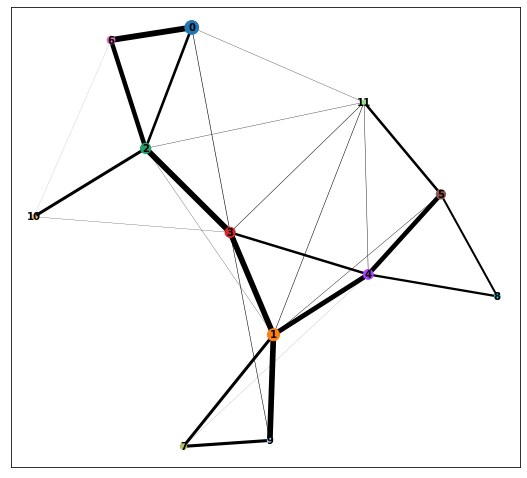

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


In [41]:
# Perform PCA and Louvain clustering for the ~2500 genes
sc.tl.pca(adata_genes, n_comps=50)

sc.pp.neighbors(
    adata_genes,
    use_rep='X_pca',  
#    use_rep='Harmony',  
#    random_state=random_seed
)

sc.tl.louvain(
    adata_genes,
#    resolution=0.50,
#   resolution=0.70,
    resolution=1.00,
#    resolution=1.50,
    #    random_state=random_seed
)

sc.tl.paga(
    adata_genes,
    groups='louvain',  
)

sc.pl.paga(
    adata_genes, 
    color=['louvain'], 
    use_raw=True,
#    use_raw=False,
#    layout='fa', 
    layout='fr', 
    threshold=0.01, 
    node_size_scale=0.5,
    node_size_power=0.9, 
#    random_state=random_seed, 
)

sc.tl.umap(
    adata_genes,
    init_pos='paga', 
#    random_state=random_seed,
)

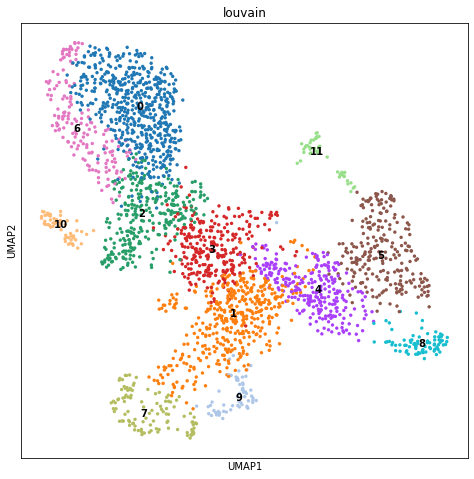

In [42]:
# Plot the genes in UMAP space
sc.pl.umap(adata_genes, color='louvain', legend_loc='on data')

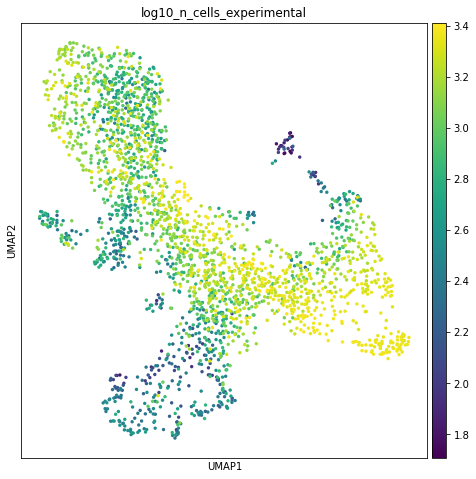

In [43]:
# Genes colored by in how many cells they are expressed
adata_genes.obs['log10_n_cells_experimental'] = np.log10(adata_genes.obs['n_cells_experimental'] + 1)
sc.pl.umap(adata_genes, color='log10_n_cells_experimental')

In [44]:
# How many genes are in each cluster? 
louvain_clusters_counter = adata_genes.obs['louvain'].value_counts()
louvain_clusters_counter

0     565
1     421
2     299
3     287
4     265
5     237
6     164
7     106
8      79
9      63
10     54
11     44
Name: louvain, dtype: int64

### 4.3 Characterize gene clusters

#### Visualize mean expr of each gene cluster on UMAP

In [46]:
adata_neural_tmp = adata_neural.copy()

In [47]:
# Calculate geometric mean (in form of log1p-transformed read counts) for each cluster of genes
for i in range(len(louvain_clusters_counter)):
    n_cluster_gene = str(i)
    cluster_gene_index = adata_genes.obs[adata_genes.obs['louvain'] == n_cluster_gene].index
    adata_neural_tmp.obs['louvain_cluster_'+n_cluster_gene+'_gene_log_mean'] = adata.raw[:, cluster_gene_index.tolist()].X.sum(axis=1)/louvain_clusters_counter[i]
    adata_neural_tmp.obs['louvain_cluster_'+n_cluster_gene+'_gene_scaled_mean'] = adata[:, cluster_gene_index.tolist()].X.sum(axis=1)/louvain_clusters_counter[i]

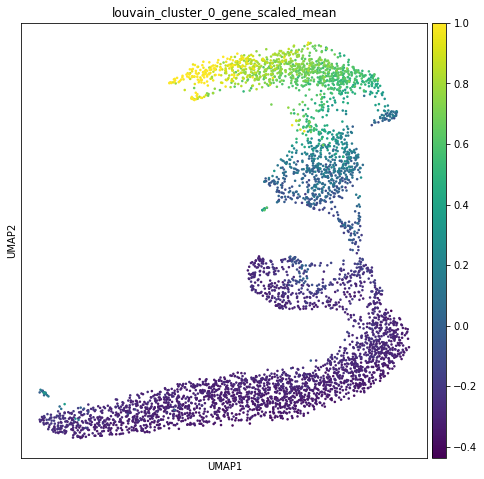

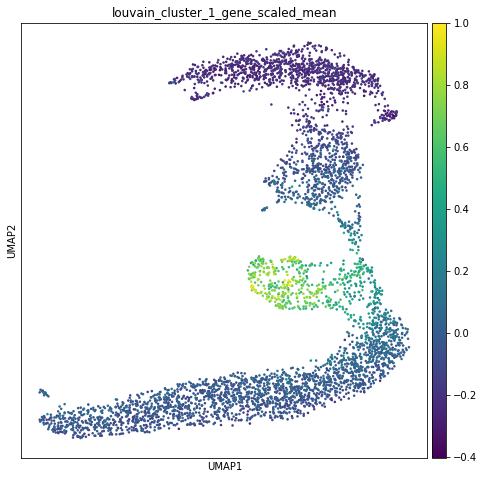

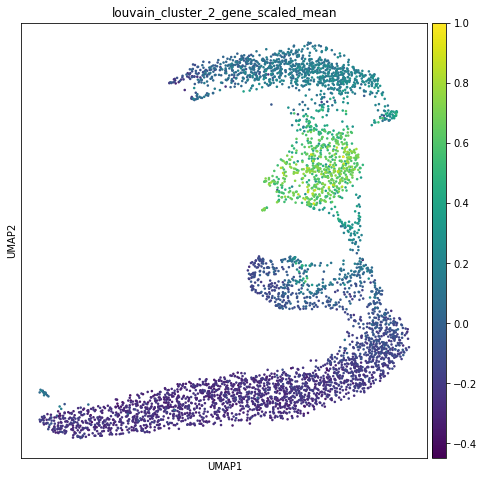

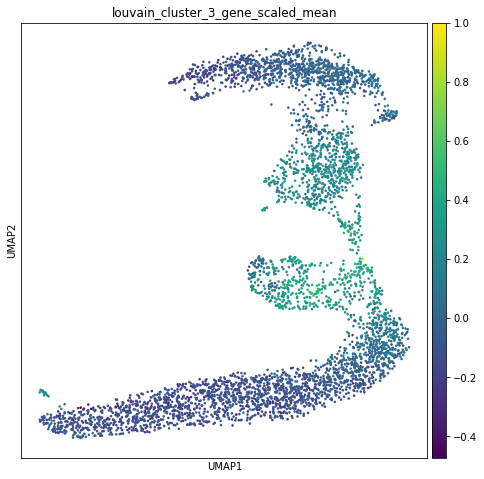

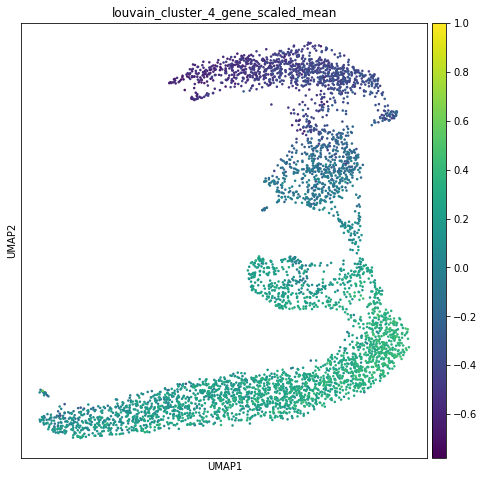

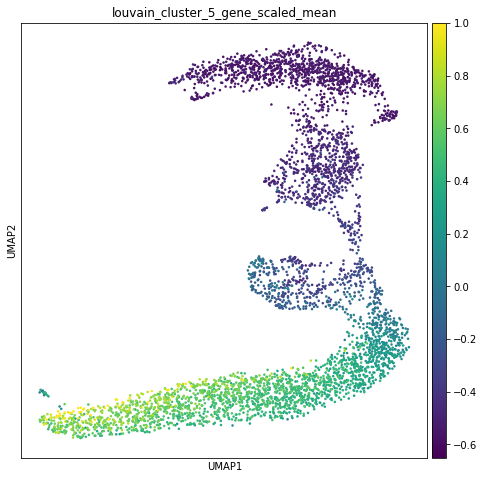

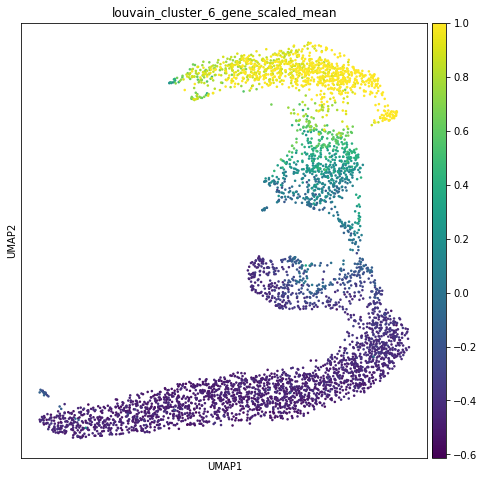

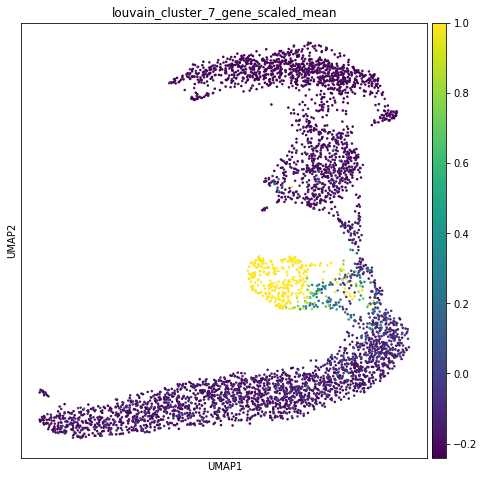

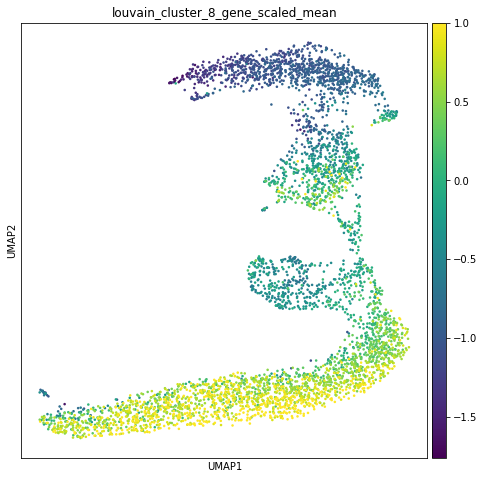

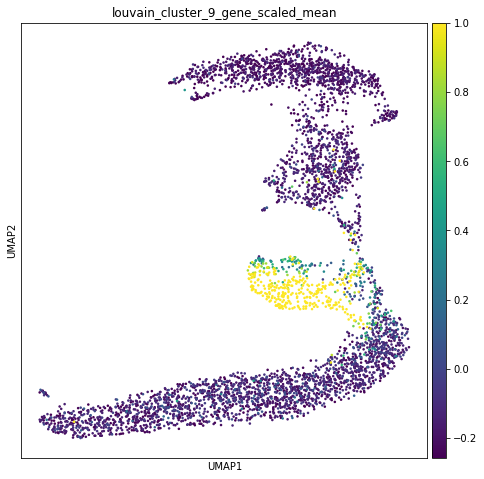

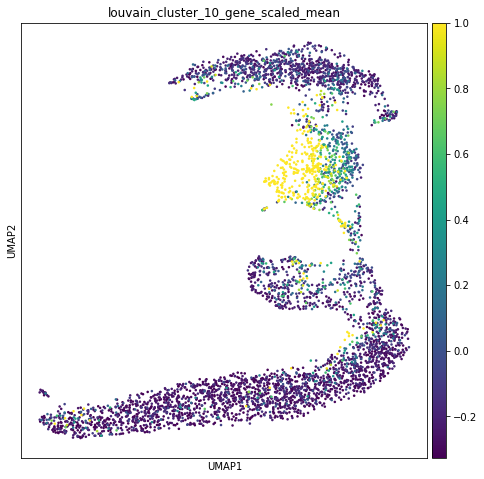

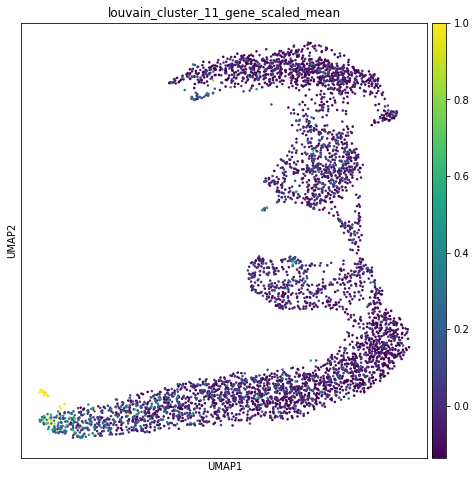

In [48]:
# Plot the scaled mean of each gene cluster on the original lenti-DLX2 neural cell map
for n_cluster_gene in range(len(louvain_clusters_counter)):
    n_cluster_gene = str(n_cluster_gene)
    sc.pl.umap(adata_neural_tmp, color='louvain_cluster_'+n_cluster_gene+'_gene_scaled_mean', vmax=1.0)

#### Visualize mean expr of each gene cluster along pseudotime

In [49]:
adata_genes.obs['louvain'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'], dtype='object')

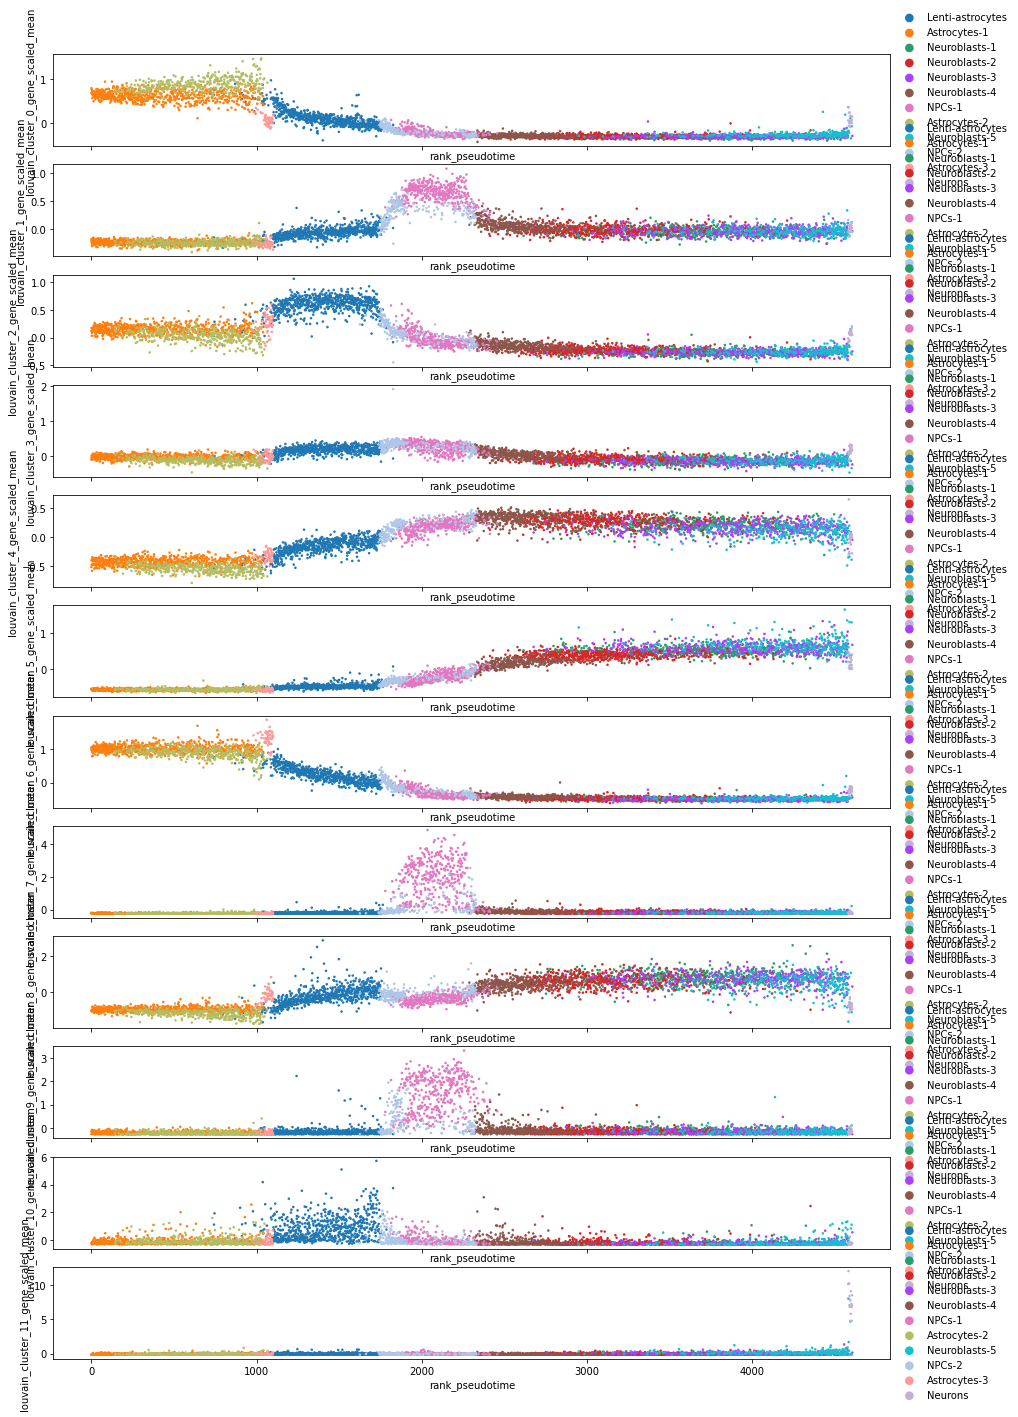

In [20]:
clusters_to_plot = adata_genes.obs['louvain'].cat.categories
fig, axes = plt.subplots(nrows=len(clusters_to_plot), ncols=1, figsize=(15,2*len(clusters_to_plot)), sharex=True)
for i, n_cluster_gene in enumerate(clusters_to_plot):
    sc.pl.scatter(adata_neural_tmp, x='rank_pseudotime', y='louvain_cluster_'+n_cluster_gene+'_gene_scaled_mean', color='louvain', use_raw=True,
                  ax=axes[i], show=False, title=''
             #save='_mainTraj_Egfr_alongPseudotime.pdf'
             )
# plt.savefig('./figures/ReprAlone_scatter_Dulken_markers_pseudotime_BL41lOnly.pdf')

#### Calculate LOESS curves for each cluster

##### With scaled mean

In [52]:
gene_louvain_scaled_mean_loess = []
for n_cluster_gene in adata_genes.obs['louvain'].cat.categories:
#    n_cluster_gene = str(i)
    x = adata_neural_tmp.obs['rank_pseudotime']
    y = adata_neural_tmp.obs['louvain_cluster_'+n_cluster_gene+'_gene_scaled_mean']

    gene_louvain_scaled_mean_loess.append(lowess(y, x, frac=0.2)) 

In [53]:
output_path = geneclustering_dir + 'gene_louvain_scaled_mean_loess'

with open(output_path, 'wb') as output_file:
 
    pickle.dump(gene_louvain_scaled_mean_loess, output_file)

In [12]:
input_path = geneclustering_dir + 'gene_louvain_scaled_mean_loess'
with open(input_path, 'rb') as input_file:
 
    gene_louvain_scaled_mean_loess = pickle.load(input_file)

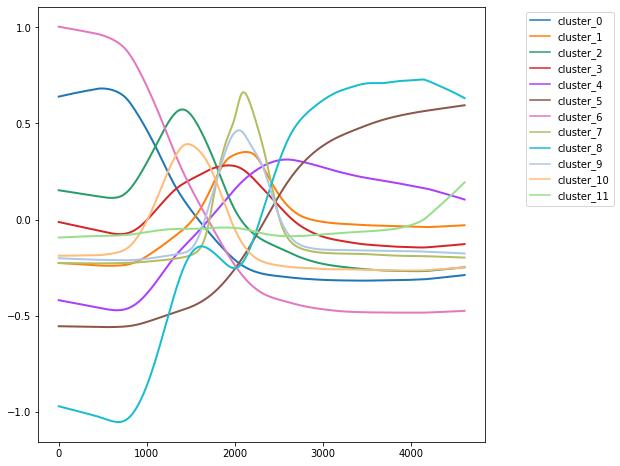

In [15]:
# Figure 4C
handles = []
for i in range(len(adata_genes.obs['louvain'].cat.categories)): 
#    print('Current cluster is: {}'.format(i))
    clr = adata_genes.uns['louvain_colors'][i]
    plt.plot(gene_louvain_scaled_mean_loess[i][:,0], gene_louvain_scaled_mean_loess[i][:,1], 
             clr,
             alpha=1, 
             linestyle='-', 
             linewidth=2 
            )
    handles.append(mpl.lines.Line2D([], [], color=clr, linestyle='-', label='cluster_'+str(i)))

plt.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.3, 1))
    
# plt.legend()
# plt.savefig('/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/99.Manuscript/Figures_v2/Figure2/linechart_loess_gene_clusters.pdf')
plt.show()    

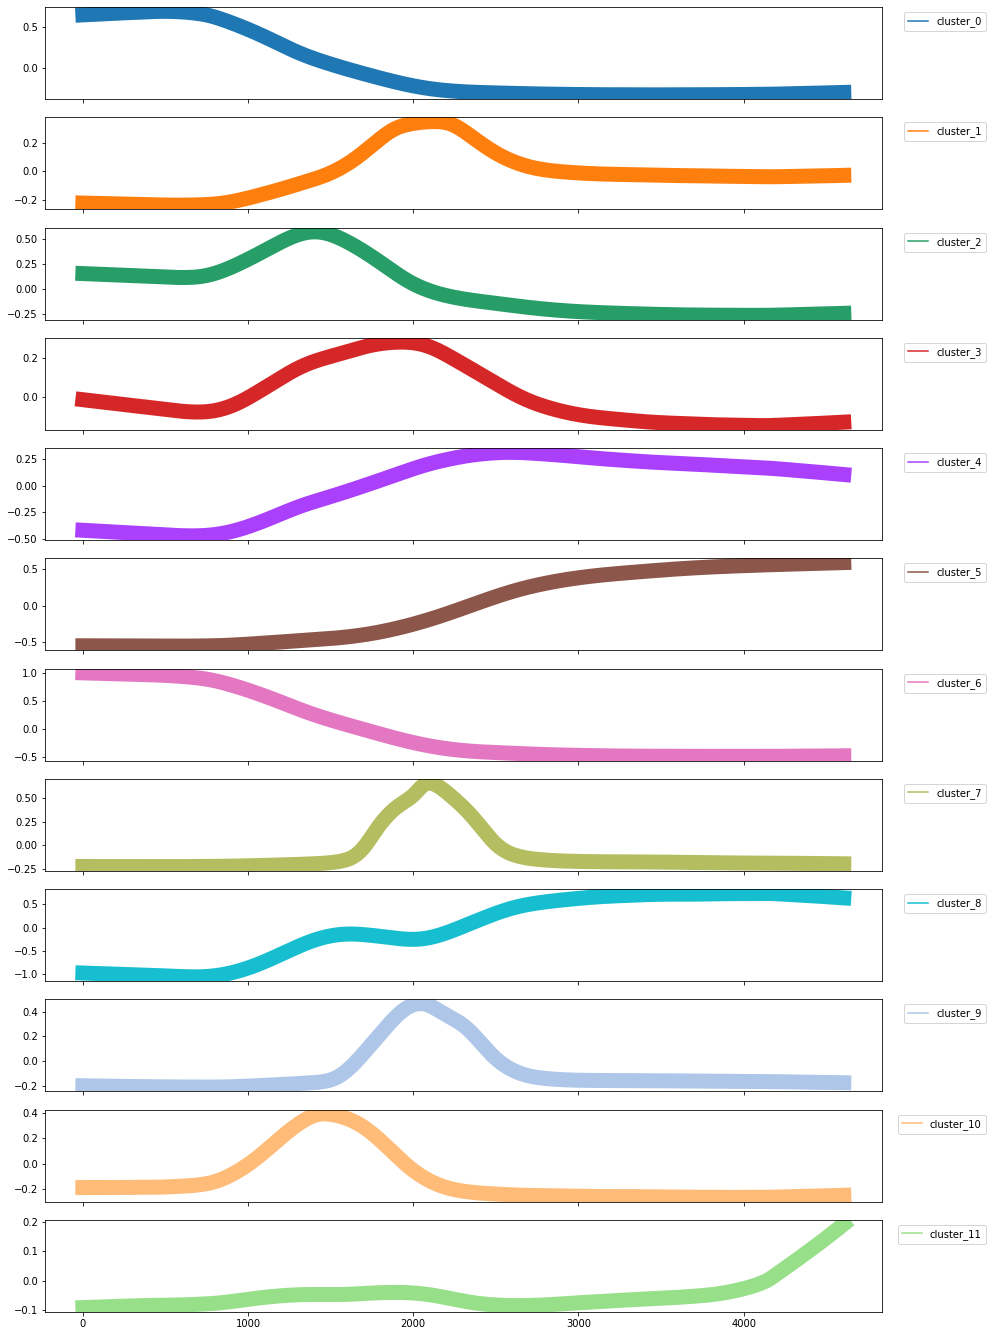

In [17]:
clusters_to_plot = adata_genes.obs['louvain'].cat.categories
fig, axes = plt.subplots(nrows=len(clusters_to_plot), ncols=1, figsize=(15,2*len(clusters_to_plot)), sharex=True)
for i, n_cluster_gene in enumerate(clusters_to_plot):
    clr = adata_genes.uns['louvain_colors'][i]
    axes[i].plot(gene_louvain_scaled_mean_loess[i][:,0], gene_louvain_scaled_mean_loess[i][:,1], 
             clr,
             alpha=1, 
             linestyle='-', 
             linewidth=15
            )
    handle = mpl.lines.Line2D([], [], color=clr, linestyle='-', label='cluster_'+str(i))
    axes[i].legend(handles=[handle], loc='upper right', bbox_to_anchor=(1.13, 1))
plt.savefig('./figures/ReprAlone_gene_clusters_loess_pseudotime.pdf')

#### Plot heatmap for gene cluster expression in cell clusters

In [23]:
adata_neural_tmp

AnnData object with n_obs × n_vars = 4607 × 2499 
    obs: 'library_name', 'batch', 'lenti_count', 'lenti_log1p_count', 'tdT_count', 'tdT_log1p_count', 'doublet_scores', 'predicted_doublets', 'n_counts', 'log_counts', 'n_genes', 'mt_count', 'mt_frac', 'n_counts_all', 'louvain', 'dpt_pseudotime', 'rank_pseudotime', 'louvain_cluster_0_gene_log_mean', 'louvain_cluster_0_gene_scaled_mean', 'louvain_cluster_1_gene_log_mean', 'louvain_cluster_1_gene_scaled_mean', 'louvain_cluster_2_gene_log_mean', 'louvain_cluster_2_gene_scaled_mean', 'louvain_cluster_3_gene_log_mean', 'louvain_cluster_3_gene_scaled_mean', 'louvain_cluster_4_gene_log_mean', 'louvain_cluster_4_gene_scaled_mean', 'louvain_cluster_5_gene_log_mean', 'louvain_cluster_5_gene_scaled_mean', 'louvain_cluster_6_gene_log_mean', 'louvain_cluster_6_gene_scaled_mean', 'louvain_cluster_7_gene_log_mean', 'louvain_cluster_7_gene_scaled_mean', 'louvain_cluster_8_gene_log_mean', 'louvain_cluster_8_gene_scaled_mean', 'louvain_cluster_9_gene_log

In [24]:
gene_cluster_activity = pd.DataFrame(index=adata_genes.obs['louvain'].cat.categories)
for cluster in adata_neural_tmp.obs['louvain'].cat.categories:
#    cluster = 'Astrocytes-resident1'

    cell_index = adata_neural_tmp.obs.index[adata_neural_tmp.obs['louvain']==cluster]

    col_index = []
    for gene_cluster in gene_cluster_activity.index:
        col_index.append('louvain_cluster_'+gene_cluster+'_gene_scaled_mean')

    df_cluster = adata_neural_tmp.obs.loc[cell_index, col_index]

    gene_cluster_activity[cluster] = df_cluster.mean(axis=0).values

In [25]:
gene_cluster_activity.index = col_index

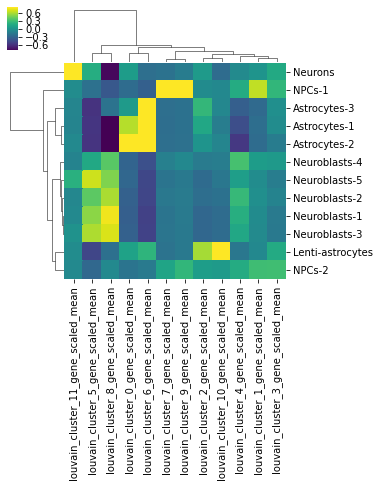

In [27]:
# Figure S4D
g = sns.clustermap(gene_cluster_activity.T, 
                    row_cluster=True, 
                    col_cluster=True, 
#                     row_colors=gene_color,
#                     col_colors=[cell_louvain_color,cell_rank_color],
                    cmap='viridis',
                    figsize=(5,5),
                    vmin=-0.8, 
                    vmax=0.8, 
#                     xticklabels=False, 
#                     yticklabels=yticklabels, 
                    rasterized=True )


plt.savefig('./figures/Heatmap_gene_cluster_means_rasterized.pdf', 
          dpi=600)

#### Print each cluster into csv

In [60]:
for cluster in adata_genes.obs['louvain'].cat.categories:
    gene_index = adata_genes.obs.index[adata_genes.obs['louvain']==cluster].tolist()
    df_cluster = pd.DataFrame(data={'genes': gene_index})
    df_cluster.to_csv(geneclustering_dir+'cluster'+cluster+'_genes.csv')

#### Save the data

In [62]:
adata_neural_tmp.write(geneclustering_dir + 'adata_neural_ReprAlone_geneClusters.h5ad')

In [22]:
adata_neural_tmp = sc.read(geneclustering_dir + 'adata_neural_ReprAlone_geneClusters.h5ad' )

In [65]:
output_path = geneclustering_dir + 'adata_genes'

with open(output_path, 'wb') as output_file:
 
    pickle.dump(adata_genes, output_file)

In [14]:
input_path = geneclustering_dir + 'adata_genes'
with open(input_path, 'rb') as input_file:
 
    adata_genes = pickle.load(input_file)

In [15]:
adata_genes

AnnData object with n_obs × n_vars = 2584 × 4607 
    obs: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'p_val_adj', 'n_counts', 'n_cells_experimental', 'louvain', 'log10_n_cells_experimental'
    var: 'library_name', 'batch', 'lenti_count', 'lenti_log1p_count', 'tdT_count', 'tdT_log1p_count', 'doublet_scores', 'predicted_doublets', 'n_counts', 'log_counts', 'n_genes', 'mt_count', 'mt_frac', 'n_counts_all', 'louvain', 'dpt_pseudotime', 'rank_pseudotime'
    uns: 'pca', 'neighbors', 'louvain', 'paga', 'louvain_sizes', 'louvain_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

### 4.4 Plot heatmap for individual genes

In [68]:
adata_genes

AnnData object with n_obs × n_vars = 2584 × 4607 
    obs: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'p_val_adj', 'n_counts', 'n_cells_experimental', 'louvain', 'log10_n_cells_experimental'
    var: 'library_name', 'batch', 'lenti_count', 'lenti_log1p_count', 'tdT_count', 'tdT_log1p_count', 'doublet_scores', 'predicted_doublets', 'n_counts', 'log_counts', 'n_genes', 'mt_count', 'mt_frac', 'n_counts_all', 'louvain', 'dpt_pseudotime', 'rank_pseudotime'
    uns: 'pca', 'neighbors', 'louvain', 'paga', 'louvain_sizes', 'louvain_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

##### Calculate cell order (based on pseudotime)

In [28]:
cell_order = pd.DataFrame(adata_genes.var['rank_pseudotime'])

cell_order['order'] = range(cell_order.shape[0])

cell_order.sort_values(by='rank_pseudotime', axis=0, ascending=True, inplace=True)

##### Calculate gene order (based on cluster and expression timing)

In [29]:
geneclustering_dir = data_dir + 'GeneClustering/'

In [30]:
input_path = geneclustering_dir + 'gene_louvain_scaled_mean_loess'
with open(input_path, 'rb') as input_file:
 
    gene_louvain_scaled_mean_loess = pickle.load(input_file)

In [31]:
max_pos = []
for loess in gene_louvain_scaled_mean_loess:
    max_pos.append(loess[:,0][np.where(loess[:,1] == loess[:,1].max(), True, False)][0])

In [32]:
cluster_order = pd.DataFrame({'max_pos': max_pos})

cluster_order.sort_values(by='max_pos', axis=0, ascending=True, inplace=True)

In [33]:
gene_order = []
# for n_cluster in adata_genes.obs['louvain'].unique():
# for n_cluster in [str(i) for i in range(10)]:
for n_cluster in [str(i) for i in cluster_order.index]:
    for gene in adata_genes.obs.index[adata_genes.obs['louvain']==n_cluster]:
        gene_order.append(adata_genes.obs.index.get_loc(gene))

##### Make color vectors for genes (rows) and cells (columns) so that they match their corresponding Louvain colors

In [34]:
gene_color = []
for gene_louvain in adata_genes.obs.iloc[gene_order]['louvain']:
    gene_color.append(adata_genes.uns['louvain_colors'][int(gene_louvain)])

In [35]:
cell_louvain_color = []
for cell_louvain in adata_genes.var['louvain'][cell_order['order'].tolist()]:
    index = adata_neural_tmp.obs['louvain'].cat.categories.get_loc(cell_louvain)
    cell_louvain_color.append(adata_neural_tmp.uns['louvain_colors'][index])

In [36]:
cell_rank_color = sns.color_palette('YlOrBr', n_colors=adata_genes.var.shape[0])

In [37]:
genes_in_order = adata_genes[gene_order, :].obs.index.tolist()

In [38]:
genes_to_label = ['Aldh1l1', 'Clu', 'Id3', 'Rpl32', 'Ascl1', 'Cdk1', 'Mki67', 'Ccna2', 'Dlx1', 'Dlx2', 'Dcx', 'Dlx6os1', 'Calb2']

In [39]:
yticklabels = []
for gene in genes_in_order:
    if gene in genes_to_label:
        yticklabels.append(gene)
    else:
        yticklabels.append('')

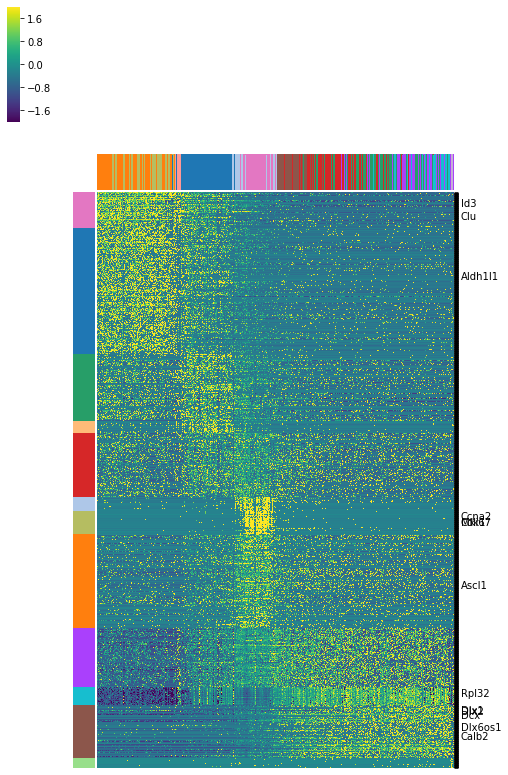

In [40]:
# Figure 4D
g = sns.clustermap(adata_genes.X[gene_order, :][:, cell_order['order'].tolist()], 
                    row_cluster=False, 
                    col_cluster=False, 
                    row_colors=gene_color,
#                    col_colors=[cell_louvain_color,cell_rank_color],
                    col_colors=cell_louvain_color,
                    cmap='viridis',
                    figsize=(8,14),
                    vmin=-2, 
                    vmax=2, 
                    xticklabels=False, 
                    yticklabels=yticklabels, 
                    rasterized=True)

plt.savefig('./figures/Heatmap_gene_clusters_rasterized.pdf',
dpi=400)

### 4.5 Validate gene clusters

#### Overlap with Lindtner et al., 2019

#### 4.5.1 DEGs

In [41]:
Lindtner_genes = pd.read_csv('/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/analysis/10.Comparison_w_Lindtner2019/DE_genes/DE_genes_Lindtner2019.csv')

In [42]:
down_genes = Lindtner_genes['Gene'][(Lindtner_genes['logFC'] < 0).tolist()].tolist()

In [43]:
up_genes = Lindtner_genes['Gene'][(Lindtner_genes['logFC'] > 0).tolist()].tolist()

#### Down genes

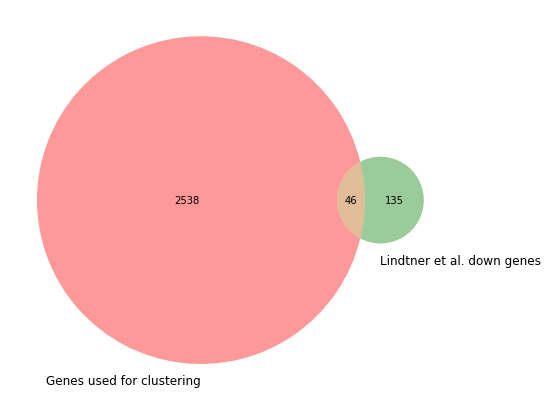

In [44]:
AB = len(intersection(down_genes, adata_genes.obs.index))
overlap = AB

Ab = len(adata_genes.obs.index) - AB
aB = len(down_genes) - AB

venn2(subsets = (Ab, aB, AB), 
              set_labels = ('Genes used for clustering', 
                        'Lindtner et al. down genes'))

Cluster 5 is significantly enriched in down genes
Adjusted p value is 7.36780340114429e-35
['Robo2', 'Sp8', 'Syt6', 'Adarb2', 'Bcl11a', 'Zeb2', 'Dlx2', 'Abracl', 'Elmo1', 'Mpped2', 'Erbb4', 'Gm13889', 'Gad1', 'Enox1', 'Dlx1', 'Dlx6os1', 'Tiam2', 'Slc32a1', 'Dpp10', 'Dlx5', 'Pfn2', 'Nrxn3', 'Plekhh2', 'Mgat4c', 'Cdca7', 'Gad2', 'Nudt4', 'Arx', 'S100a10']


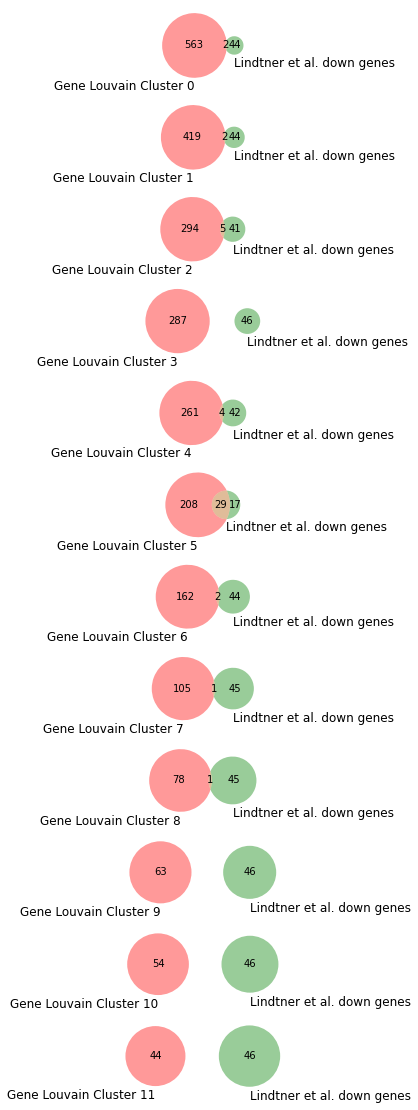

In [45]:
# Overlap with down genes (in Dlx1-Dlx2-)
figure, axes = plt.subplots(len(adata_genes.obs['louvain'].cat.categories), figsize=(140, 20))

for i, n_cluster in enumerate(adata_genes.obs['louvain'].cat.categories):

    louvain_query_genes = [gene for gene in adata_genes.obs.index if adata_genes.obs['louvain'][gene] == n_cluster]

    AB = len(intersection(louvain_query_genes, down_genes))
#     print(intersection(louvain_query_genes, down_genes))

    Ab = len(louvain_query_genes) - AB

    aB = overlap - AB

    p = venn2(subsets = (Ab, aB, AB), 
              set_labels = ('Gene Louvain Cluster {}'.format(n_cluster), 
                        'Lindtner et al. down genes'), 
              ax=axes[i])
    

        # Make contigency table with the format:
    # [[queried cluster pos, rest clusters pos],
    #  [queried cluster neg, rest clusters neg]]
    # queried_cluster = '0'

    
    obs = np.array([[AB, aB], [Ab, adata_genes.X.shape[0] - AB - aB - Ab]])

    _, p_val, _, _ = chi2_contingency(obs)

    p_val_adj = p_val * len(adata_genes.obs['louvain'].cat.categories)
    
    direction_test = AB/Ab > aB/(adata_genes.X.shape[0] - AB - aB - Ab)

    if p_val_adj < 0.05:
#    if p_val < 0.05:
        if direction_test:
            print('Cluster', n_cluster, 'is significantly enriched in down genes')
        else: 
            print('Cluster', n_cluster, 'is significantly depleted of down genes')
        print('Adjusted p value is {}'.format(p_val_adj))
#        print('P value is {}'.format(p_val))
        print(intersection(louvain_query_genes, down_genes))
    
plt.show()

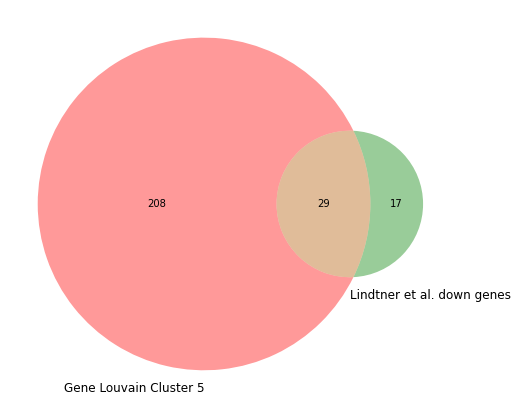

In [47]:
# Figure S4E
louvain_query_genes = [gene for gene in adata_genes.obs.index if adata_genes.obs['louvain'][gene] == '5']

AB = len(intersection(louvain_query_genes, down_genes))

Ab = len(louvain_query_genes) - AB

aB = overlap - AB

p = venn2(subsets = (Ab, aB, AB), 
              set_labels = ('Gene Louvain Cluster {}'.format(5), 
                        'Lindtner et al. down genes'), 
#              ax=axes[i]
         )
plt.savefig('./figures/Venn_cluster5_Lindtner_down.pdf', 
           dpi=600)

#### Up genes

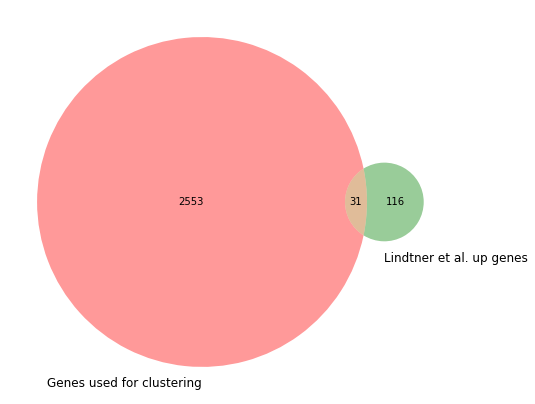

In [38]:
AB = len(intersection(up_genes, adata_genes.obs.index))
overlap = AB

Ab = len(adata_genes.obs.index) - AB
aB = len(up_genes) - AB

venn2(subsets = (Ab, aB, AB), 
              set_labels = ('Genes used for clustering', 
                        'Lindtner et al. up genes'))

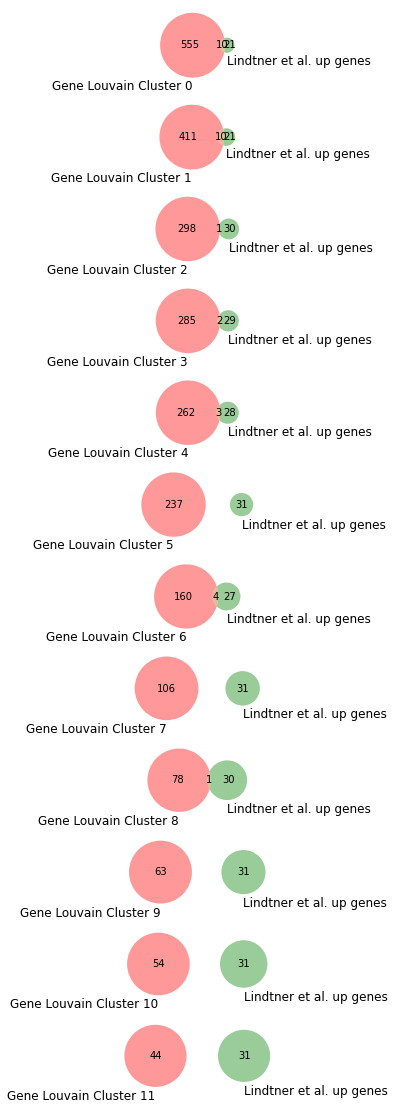

In [39]:
# Overlap with down genes (in Dlx1-Dlx2-)
figure, axes = plt.subplots(len(adata_genes.obs['louvain'].cat.categories), figsize=(140, 20))

for i, n_cluster in enumerate(adata_genes.obs['louvain'].cat.categories):

    louvain_query_genes = [gene for gene in adata_genes.obs.index if adata_genes.obs['louvain'][gene] == n_cluster]

    AB = len(intersection(louvain_query_genes, up_genes))
#     print(intersection(louvain_query_genes, down_genes))

    Ab = len(louvain_query_genes) - AB

    aB = overlap - AB

    p = venn2(subsets = (Ab, aB, AB), 
              set_labels = ('Gene Louvain Cluster {}'.format(n_cluster), 
                        'Lindtner et al. up genes'), 
              ax=axes[i])
    

        # Make contigency table with the format:
    # [[queried cluster pos, rest clusters pos],
    #  [queried cluster neg, rest clusters neg]]
    # queried_cluster = '0'

    
    obs = np.array([[AB, aB], [Ab, adata_genes.X.shape[0] - AB - aB - Ab]])

    _, p_val, _, _ = chi2_contingency(obs)

    p_val_adj = p_val * len(adata_genes.obs['louvain'].cat.categories)
    
    direction_test = AB/Ab > aB/(adata_genes.X.shape[0] - AB - aB - Ab)

    if p_val_adj < 0.05:
#    if p_val < 0.05:
        if direction_test:
            print('Cluster', n_cluster, 'is significantly enriched in up genes')
        else: 
            print('Cluster', n_cluster, 'is significantly depleted of up genes')
        print('Adjusted p value is {}'.format(p_val_adj))
#        print('P value is {}'.format(p_val))
        print(intersection(louvain_query_genes, up_genes))
    
plt.show()

#### 4.5.2 RE-associated genes

In [40]:
Lindtner_peaks = pd.read_csv('/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/analysis/10.Comparison_w_Lindtner2019/REs/Dlx_ChIP-seq_peaks.csv')

/home2/s418610/.conda/envs/py37_res_PAGA/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,20,121,123,124,125,126,128) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [41]:
aRE_regions = Lindtner_peaks[Lindtner_peaks['a.RE.bdg'] == 1]

aRE_genes = aRE_regions['Gene']

aRE_genes = aRE_genes.unique().tolist()

rRE_regions = Lindtner_peaks[Lindtner_peaks['r.RE.bdg'] == 1]

rRE_genes = rRE_regions['Gene']

rRE_genes = rRE_genes.unique().tolist()

##### aRE-genes

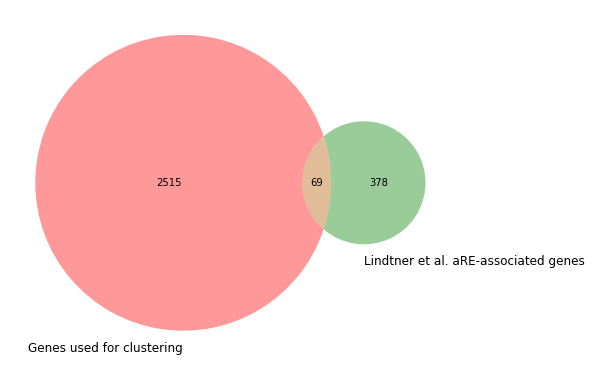

In [42]:
AB = len(intersection(aRE_genes, adata_genes.obs.index))
overlap = AB

Ab = len(adata_genes.obs.index) - AB
aB = len(aRE_genes) - AB

venn2(subsets = (Ab, aB, AB), 
              set_labels = ('Genes used for clustering', 
                        'Lindtner et al. aRE-associated genes'))

Cluster 5 is significantly enriched in a.RE genes
Adjusted p value is 1.8718334104751418e-13
['Elmo1', 'Celf4', 'Dlx2', 'Bcl11a', 'Adarb2', 'Dlx5', 'Foxp2', 'Khdrbs3', 'Abracl', 'Tiam2', 'Mpped2', 'Nnat', 'Sez6', 'C530008M17Rik', 'Nrxn3', 'Gad2', 'Nav1', 'Asxl3', 'Nol4', 'Sp8', 'Dlx1', 'Gad1', 'Sp9', 'Anks1b', 'Dlx6os1']


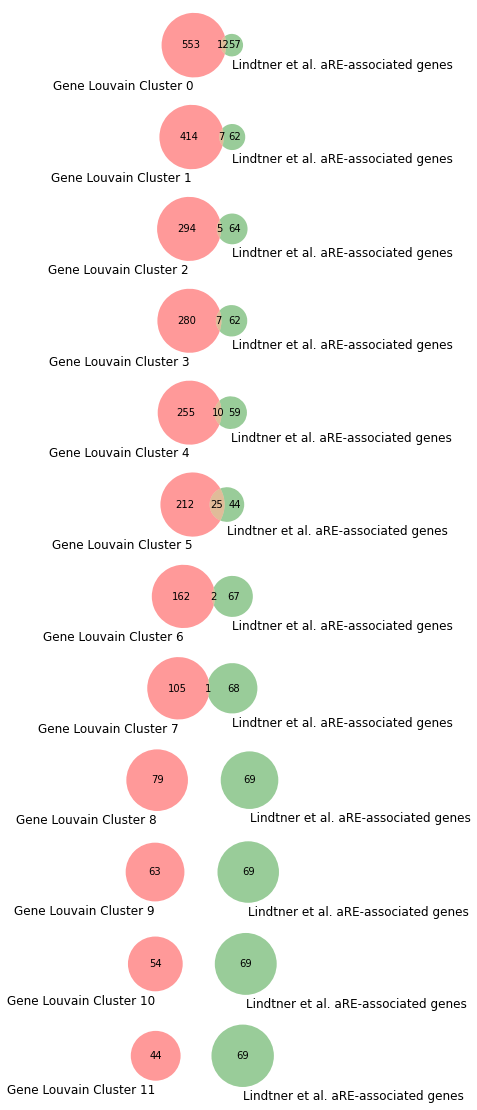

In [43]:
# Overlap with down genes (in Dlx1-Dlx2-)
figure, axes = plt.subplots(len(adata_genes.obs['louvain'].cat.categories), figsize=(140, 20))

for i, n_cluster in enumerate(adata_genes.obs['louvain'].cat.categories):

    louvain_query_genes = [gene for gene in adata_genes.obs.index if adata_genes.obs['louvain'][gene] == n_cluster]

    AB = len(intersection(louvain_query_genes, aRE_genes))
#    print(intersection(louvain_query_genes, aRE_genes))

    Ab = len(louvain_query_genes) - AB

    aB = overlap - AB

    p = venn2(subsets = (Ab, aB, AB), 
              set_labels = ('Gene Louvain Cluster {}'.format(n_cluster), 
                        'Lindtner et al. aRE-associated genes'), 
              ax=axes[i])

    obs = np.array([[AB, aB], [Ab, adata_genes.X.shape[0] - AB - aB - Ab]])

    _, p_val, _, _ = chi2_contingency(obs)

    p_val_adj = p_val * len(adata_genes.obs['louvain'].cat.categories)
    
    direction_test = AB/Ab > aB/(adata_genes.X.shape[0] - AB - aB - Ab)

    if p_val_adj < 0.05:
#    if p_val < 0.05:
        if direction_test:
            print('Cluster', n_cluster, 'is significantly enriched in a.RE genes')
        else: 
            print('Cluster', n_cluster, 'is significantly depleted of a.RE genes')
        print('Adjusted p value is {}'.format(p_val_adj))
        print(intersection(louvain_query_genes, aRE_genes))
    
plt.show()

##### rRE-genes

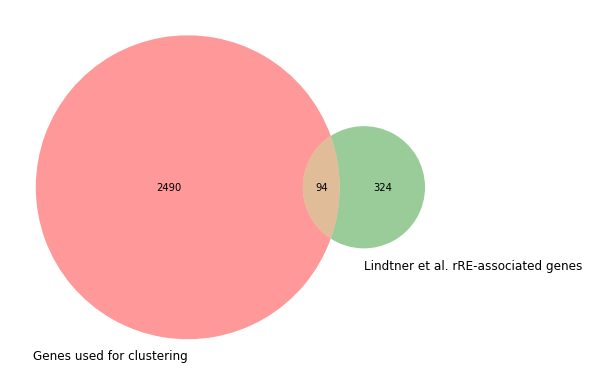

In [44]:
AB = len(intersection(rRE_genes, adata_genes.obs.index))
overlap = AB

Ab = len(adata_genes.obs.index) - AB
aB = len(rRE_genes) - AB

venn2(subsets = (Ab, aB, AB), 
              set_labels = ('Genes used for clustering', 
                        'Lindtner et al. rRE-associated genes'))

Cluster 5 is significantly enriched in r.RE genes
Adjusted p value is 0.003875921274460515
['Pbx3', 'Dlx2', 'Gm17750', 'Mex3b', 'Arx', 'Cd24a', 'Zfp618', 'Elavl2', 'Syt1', 'Nav3', 'Ptma', 'Casp3', 'Nfib', 'Cited2', 'Fnbp1l', 'Dcx', 'Calm2', 'Dlx1', 'Pafah1b3']


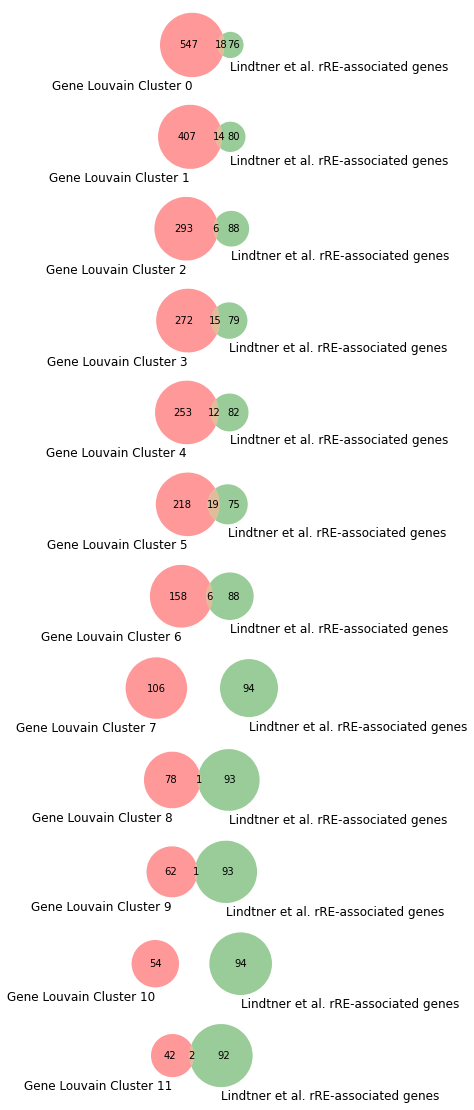

In [45]:
# Overlap with down genes (in Dlx1-Dlx2-)
figure, axes = plt.subplots(len(adata_genes.obs['louvain'].cat.categories), figsize=(140, 20))

for i, n_cluster in enumerate(adata_genes.obs['louvain'].cat.categories):

    louvain_query_genes = [gene for gene in adata_genes.obs.index if adata_genes.obs['louvain'][gene] == n_cluster]

    AB = len(intersection(louvain_query_genes, rRE_genes))
#    print(intersection(louvain_query_genes, aRE_genes))

    Ab = len(louvain_query_genes) - AB

    aB = overlap - AB

    p = venn2(subsets = (Ab, aB, AB), 
              set_labels = ('Gene Louvain Cluster {}'.format(n_cluster), 
                        'Lindtner et al. rRE-associated genes'), 
              ax=axes[i])

    obs = np.array([[AB, aB], [Ab, adata_genes.X.shape[0] - AB - aB - Ab]])

    _, p_val, _, _ = chi2_contingency(obs)

    p_val_adj = p_val * len(adata_genes.obs['louvain'].cat.categories)
    
    direction_test = AB/Ab > aB/(adata_genes.X.shape[0] - AB - aB - Ab)

    if p_val_adj < 0.05:
#    if p_val < 0.05:
        if direction_test:
            print('Cluster', n_cluster, 'is significantly enriched in r.RE genes')
        else: 
            print('Cluster', n_cluster, 'is significantly depleted of r.RE genes')
        print('Adjusted p value is {}'.format(p_val_adj))
        print(intersection(louvain_query_genes, rRE_genes))
    
plt.show()

## Miscellaneous: plotting genes and gene sets

### Import function and load data

In [58]:
from itertools import compress

In [49]:
neural_data_dir

'/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/analysis/Cluster_with_10X_20k/data/10x_remapped/Revision/NeuralOnly/'

In [49]:
adata_experiment_neural = sc.read(neural_data_dir + 'ReprAlone_NeuralOnly_postFiltering_log_pcs50_Harmony_louvain_ann_rankPseudotime.h5ad')

### Figure S6A

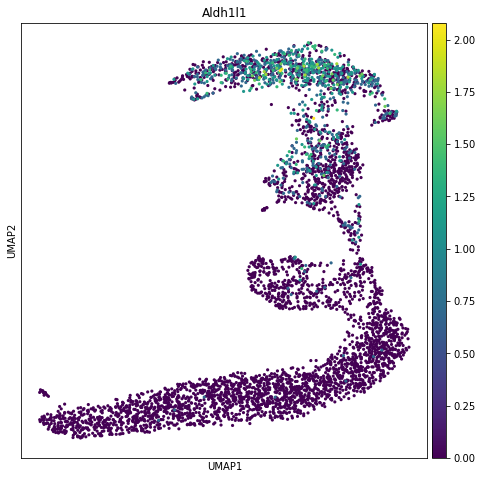

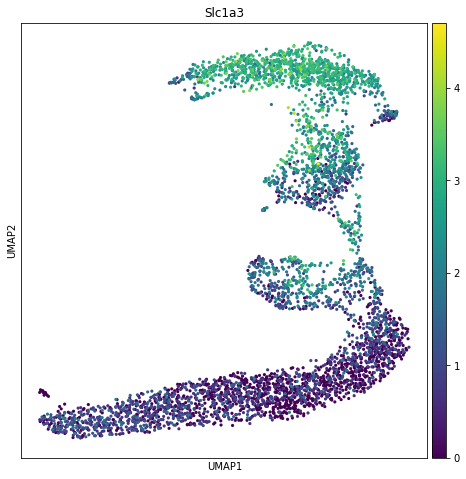

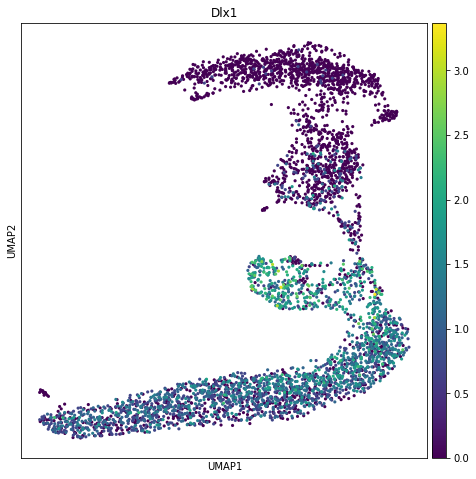

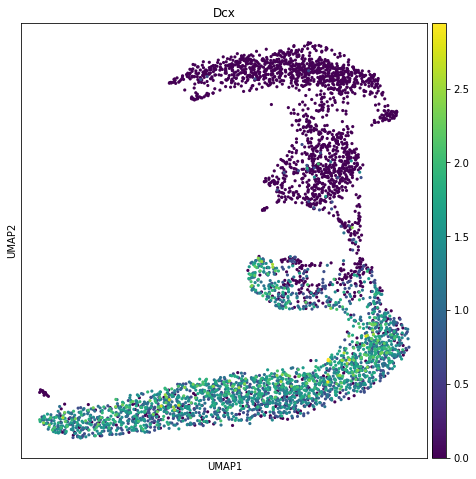

In [50]:
# Figure S6A
sc.pl.umap(adata_experiment_neural, color='Aldh1l1', size=40, use_raw=True, 
#           save='_experimental_MT_Aldh1l1.pdf'
          )
sc.pl.umap(adata_experiment_neural, color='Slc1a3', size=40, use_raw=True, 
#           save='_experimental_MT_Slc1a3.pdf'
          )
sc.pl.umap(adata_experiment_neural, color='Dlx1', size=40, use_raw=True, 
#           save='_experimental_MT_Dlx1.pdf'
          )
sc.pl.umap(adata_experiment_neural, color='Dcx', size=40, use_raw=True, 
#           save='_experimental_MT_Dcx.pdf'
          )

### Figure S6B

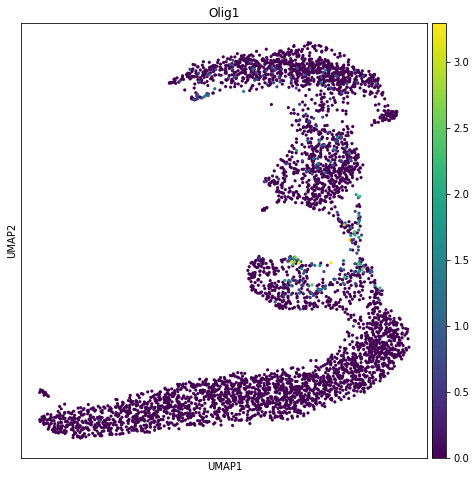

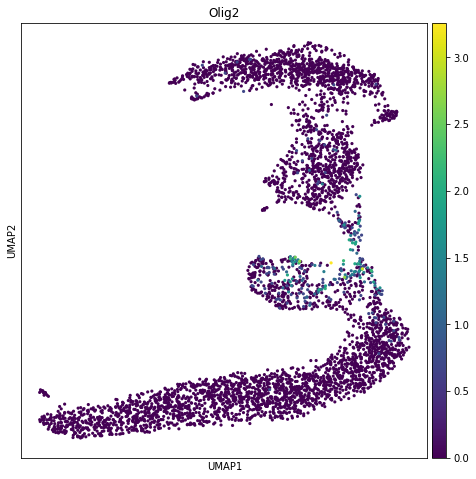

In [51]:
# Figure S6B
sc.pl.umap(adata_experiment_neural, color='Olig1', size=40, use_raw=True, 
           save='_ReprAlone_MT_Olig1.pdf'
          )
sc.pl.umap(adata_experiment_neural, color='Olig2', size=40, use_raw=True, 
           save='_ReprAlone_MT_Olig2.pdf'
          )


### Figure S6CD

In [57]:
import csv

#### Astrocyte marker expression (Figure S6C)

In [52]:
# Taken from https://www.frontiersin.org/articles/10.3389/fncel.2016.00215/full
astrocyte_markers = ['Aldoc', 'Aqp4', 'Aldh1l1', 'Gja1', 'Gfap', 'Slc1a2', 'Slc1a3', 'Nfia', 'Nes', 'Pygb', 'S100b', 'Vim']

In [53]:
index = []
for gene in astrocyte_markers:
#     print (gene in adata_experiment_neural.raw.var.index)
    index.append(gene in adata_experiment_neural.raw.var.index)

In [54]:
len(astrocyte_markers)

12

In [59]:
astrocyte_markers = list(compress(astrocyte_markers, index))

In [60]:
len(astrocyte_markers)

12

In [61]:
# Calculate mean of log-transformed expression
adata_experiment_neural.obs['astrocyte_markers_mean'] = np.array(adata_experiment_neural.raw[:,astrocyte_markers].X.mean(axis=1)).flatten()

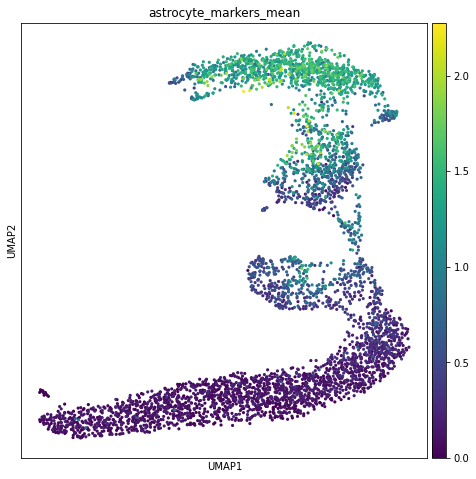

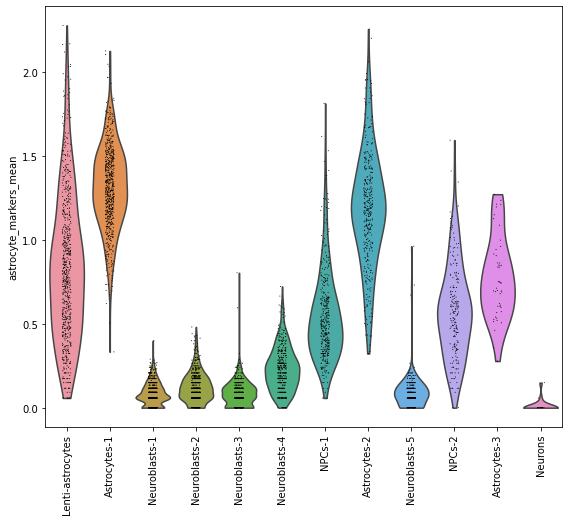

In [62]:
sc.pl.umap(adata_experiment_neural, color='astrocyte_markers_mean', size=40, 
           save='_ReprAlone_MT_astrocyte_markers_mean.pdf'
          )
sc.pl.violin(adata_experiment_neural, keys='astrocyte_markers_mean', groupby='louvain', rotation=90,
              save='_ReprAlone_MT_astroMarkers.pdf'
            )

In [64]:
with open(data_dir+'12_astrocyte_markers.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(astrocyte_markers)

#### Oxphos gene expression (Figure S6D)

In [63]:
oxphos_genes = ["Abcd1",
"Actn3",
"Actn3",
"Afg1l",
"Ak4",
"Apoc3",
"Atp5a1",
"Atp5b",
"Atp5b",
"Atp5c1",
"Atp5d",
"Atp5h",
"Atp5j",
"Atp5j2",
"Atp5l",
"Atp5o",
"Atp5pb",
"Atp7a",
"Atpsckmt",
"Atpsckmt",
"Bdnf",
"Bid",
"Ccnb1",
"Cdk1",
"Chchd10",
"Coq7",
"Coq9",
"Cox4i1",
"Cox4i2",
"Cox5a",
"Cox5b",
"Cox5b",
"Cox6a1",
"Cox6a2",
"Cox7a1",
"Cox7a2",
"Cox7a2l",
"Cox7a2l",
"Cox7c",
"Cyc1",
"Cyc1",
"Cycs",
"Cycs",
"Cyct",
"Cyct",
"Dguok",
"Dld",
"Dnajc15",
"Dnajc30",
"Fxn",
"Fxn",
"Gadd45gip1",
"Iscu",
"Lexm",
"Mecp2",
"Mlxipl",
"Msh2",
"mt-Atp6",
"mt-Co1",
"mt-Co2",
"mt-Co3",
"mt-Cytb",
"mt-Nd2",
"mt-Nd4",
"mt-Nd4",
"mt-Nd4l",
"mt-Nd5",
"Mtch2",
"Myc",
"Myc",
"Myog",
"Ndufa7",
"Ndufa7",
"Ndufa8",
"Ndufa10",
"Ndufa10",
"Ndufa12",
"Ndufaf1",
"Ndufb6",
"Ndufb6",
"Ndufb6",
"Ndufb8",
"Ndufb9",
"Ndufc2",
"Ndufs1",
"Ndufs2",
"Ndufs2",
"Ndufs6",
"Ndufs8",
"Ndufv1",
"Ndufv1",
"Ndufv2",
"Ndufv2",
"Ndufv3",
"Ndufv3",
"Nipsnap2",
"Nupr1",
"Park7",
"Park7",
"Pde2a",
"Pde12",
"Pgk1",
"Pgk2",
"Pink1",
"Pink1",
"Ppif",
"Rhoa",
"Sdha",
"Sdhaf2",
"Sdhaf2",
"Sdhc",
"Sdhd",
"Shmt2",
"Shmt2",
"Shmt2",
"Slc25a23",
"Slc25a33",
"Snca",
"Stoml2",
"Stoml2",
"Surf1",
"Taz",
"Tefm",
"Tnf",
"Uqcc2",
"Uqcc2",
"Uqcc3",
"Uqcc3",
"Uqcr10",
"Uqcrb",
"Uqcrc1",
"Uqcrc1",
"Uqcrfs1",
"Uqcrh",
"Uqcrq",
"Vcp"]

In [64]:
index = []
for gene in oxphos_genes:
#     print (gene in adata_experiment_neural.raw.var.index)
    index.append(gene in adata_experiment_neural.raw.var.index)

In [65]:
len(oxphos_genes)

136

In [66]:
oxphos_genes = list(compress(oxphos_genes, index))

In [67]:
len(oxphos_genes)

125

In [68]:
adata_experiment_neural.obs['oxphos_genes_mean'] = np.array(adata_experiment_neural.raw[:,oxphos_genes].X.mean(axis=1)).flatten()

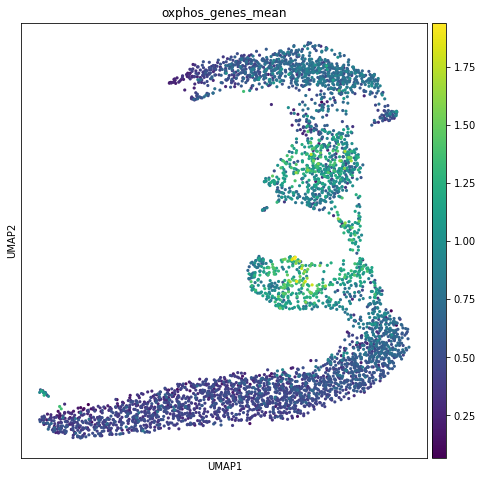

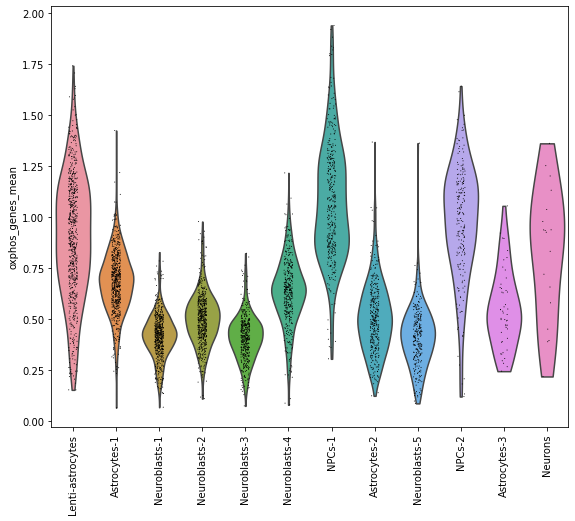

In [69]:
sc.pl.umap(adata_experiment_neural, color='oxphos_genes_mean', size=40, 
          save='_ReprAlone_MT_oxphos_125genes.pdf'
          )
sc.pl.violin(adata_experiment_neural, keys='oxphos_genes_mean', groupby='louvain', rotation=90, 
              save='_ReprAlone_MT_oxphos.pdf'
            )

In [72]:
with open(data_dir+'125_oxphos_genes.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(oxphos_genes)

In [76]:
geneclustering_dir

'/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/analysis/Cluster_with_10X_20k/data/10x_remapped/Revision/GeneClustering/'

# Misc

In [73]:
from itertools import compress

In [20]:
# Table S1: Expression of GABAergic marker genes

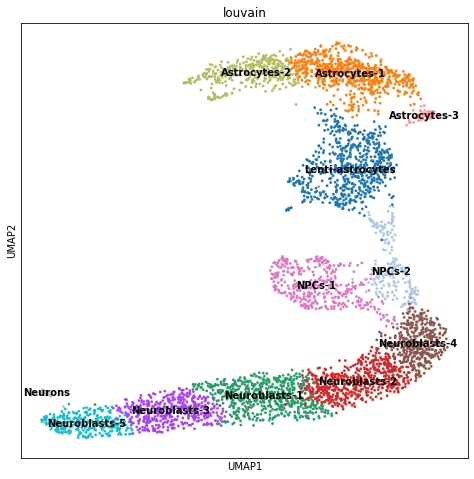

In [74]:
# Figure 4A
sc.pl.umap(adata_experiment_neural, color='louvain', legend_loc='on data', size=30, 
#          save='_Experimental_louvain.pdf'
          )

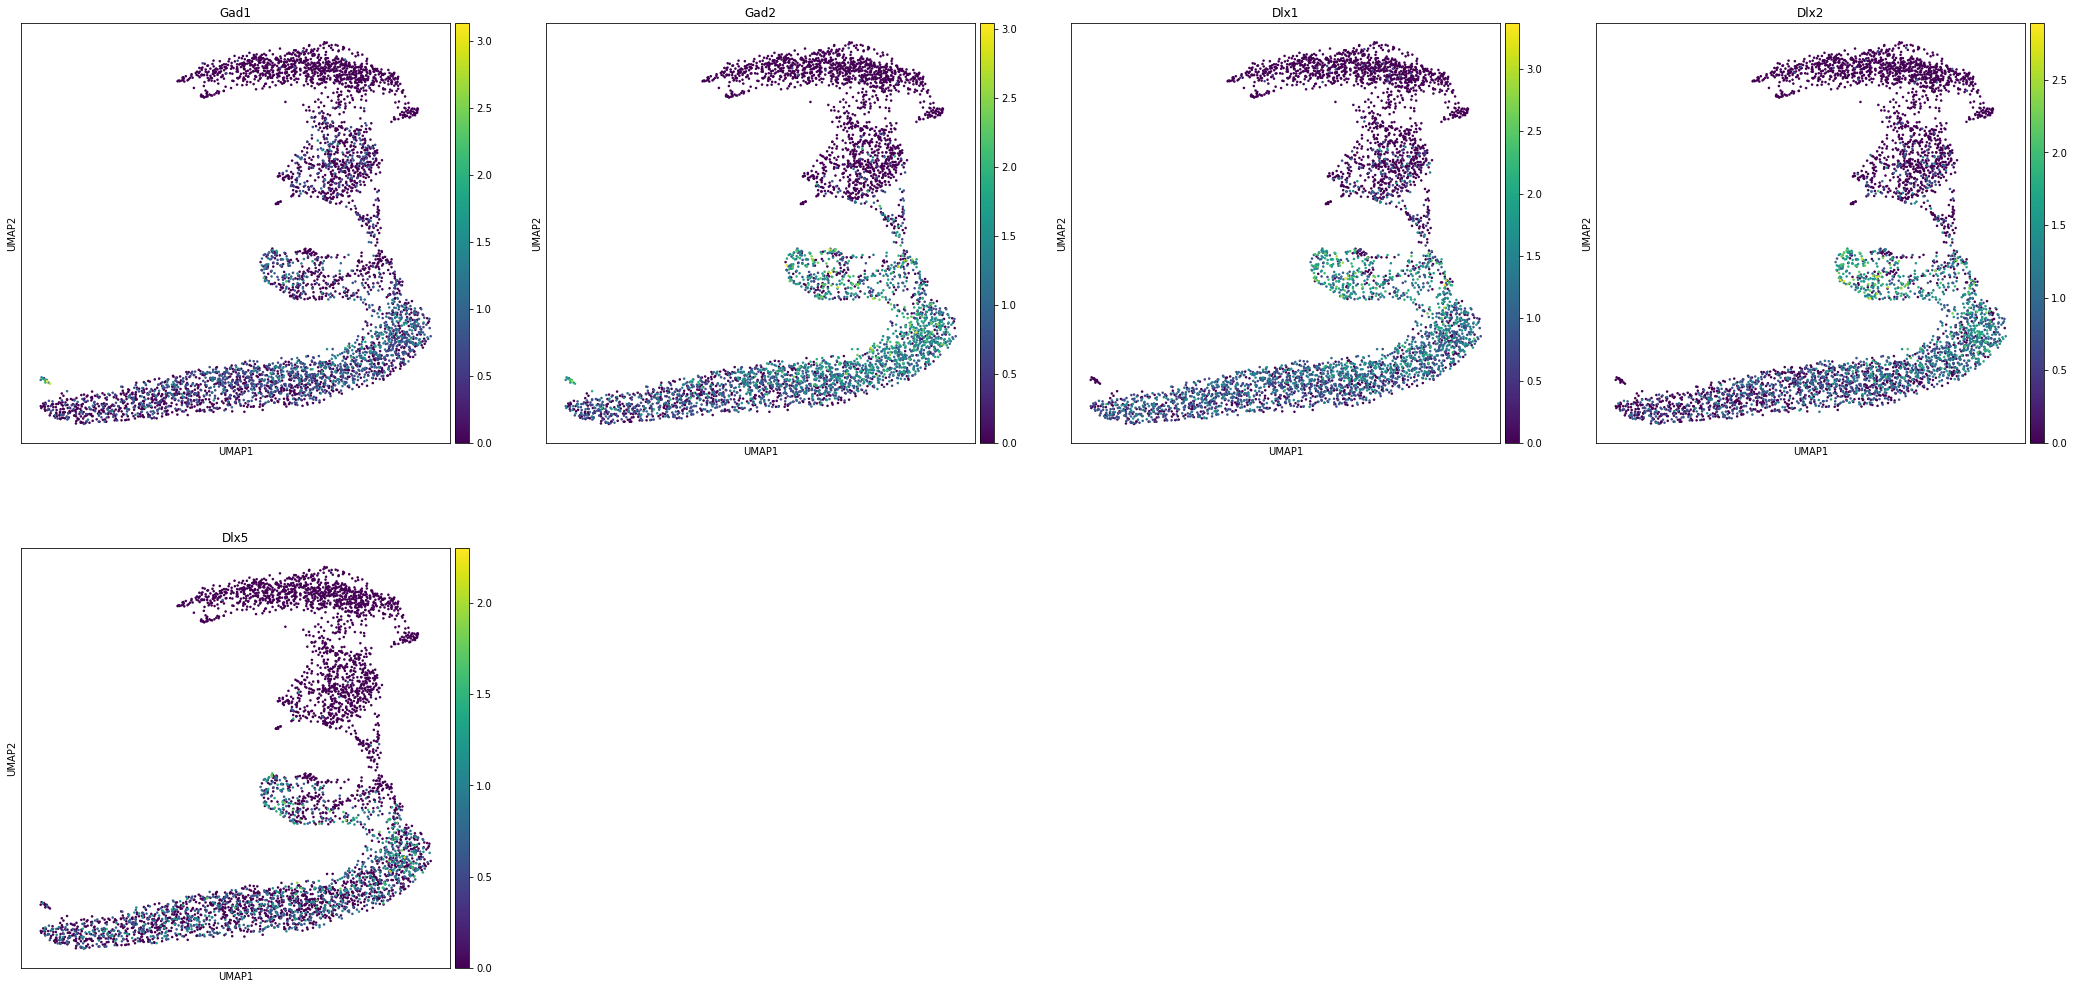

In [75]:
# GABAergic marker genes
GABA_markers = ['Gad1', 'Gad2', 'Dlx1', 'Dlx2', 'Dlx5']
sc.pl.umap(adata_experiment_neural, color=GABA_markers, # GABAergic neuron marker
                                           use_raw=True) 

In [54]:
df_GABA = pd.DataFrame(data=None, columns=['Resident astrocytes', 'Lenti-astrocytes', 'NPCs', 'Neuroblasts', 'Astro-neuroblast hybrid'], index=GABA_markers)

In [55]:
RA_index = adata_experiment_neural.obs['louvain'].isin(['Resident astrocytes-1', 'Resident astrocytes-2'])

RA_index

RA_index = list(compress(RA_index.index, RA_index.values))

assert len(RA_index)==1081

df_GABA['Resident astrocytes'] = adata_experiment_neural.raw[RA_index, :][:, GABA_markers].X.mean(axis=0).T

In [56]:
LA_index = adata_experiment_neural.obs['louvain'].isin(['Lenti-astrocytes-1', 'Lenti-astrocytes-2'])

LA_index = list(compress(LA_index.index, LA_index.values))

assert len(LA_index)==901

df_GABA['Lenti-astrocytes'] = adata_experiment_neural.raw[LA_index, :][:, GABA_markers].X.mean(axis=0).T

In [60]:
NPC_index = adata_experiment_neural.obs['louvain'].isin(['Mitotic NPCs', 'Non-mitotic NPCs'])

NPC_index = list(compress(NPC_index.index, NPC_index.values))

assert len(NPC_index)==559

df_GABA['NPCs'] = adata_experiment_neural.raw[NPC_index, :][:, GABA_markers].X.mean(axis=0).T

In [64]:
NB_index = adata_experiment_neural.obs['louvain'].isin(['Early neuroblasts', 'Mid neuroblasts-1', 'Mid neuroblasts-2', 'Late neuroblasts'])

NB_index = list(compress(NB_index.index, NB_index.values))

assert len(NB_index)==2250

df_GABA['Neuroblasts'] = adata_experiment_neural.raw[NB_index, :][:, GABA_markers].X.mean(axis=0).T

In [68]:
hybrid_index = adata_experiment_neural.obs['louvain'].isin(['Astro-neuroblast hybrid cells'])

hybrid_index = list(compress(hybrid_index.index, hybrid_index.values))

assert len(hybrid_index)==72

df_GABA['Astro-neuroblast hybrid'] = adata_experiment_neural.raw[hybrid_index, :][:, GABA_markers].X.mean(axis=0).T

In [69]:
df_GABA

Resident astrocytes  Lenti-astrocytes      NPCs  Neuroblasts  \
Gad1             0.005505          0.155940  0.298775     0.448627   
Gad2             0.003847          0.074627  0.965433     0.815649   
Dlx1             0.011542          0.133811  1.157102     0.829373   
Dlx2             0.009993          0.111397  0.948792     0.572855   
Dlx5             0.000641          0.009682  0.291336     0.338656   

      Astro-neuroblast hybrid  
Gad1                 0.460321  
Gad2                 0.796344  
Dlx1                 0.941322  
Dlx2                 0.615031  
Dlx5                 0.389093

In [70]:
df_GABA.to_csv('TableS1_GABAergic_marker.csv')